## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 5')

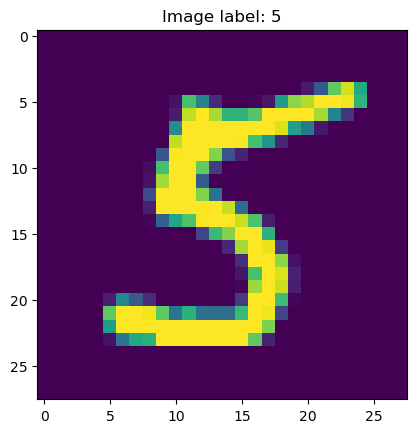

In [15]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

## Dataset analysis

In [3]:
len(train_mnist_data), len(test_mnist_data)

(60000, 10000)

In [4]:
np.bincount(train_mnist_data.targets), np.bincount(test_mnist_data.targets)

(array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

In [5]:
train_mnist_data.data.shape, train_mnist_data.data[0].flatten().shape

(torch.Size([60000, 28, 28]), torch.Size([784]))

In [6]:
np.unique(train_mnist_data.data[0])

array([  0,   1,   2,   3,   9,  11,  14,  16,  18,  23,  24,  25,  26,
        27,  30,  35,  36,  39,  43,  45,  46,  49,  55,  56,  64,  66,
        70,  78,  80,  81,  82,  90,  93,  94, 107, 108, 114, 119, 126,
       127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166,
       170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205,
       207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244,
       247, 249, 250, 251, 252, 253, 255], dtype=uint8)

In [7]:
np.unique(train_mnist_data.targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Get device for training

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Define the model class

In [23]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(7*7*32, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
                        
            nn.Linear(32, 10, bias=True),
        )
        
    def forward(self, x):
        logits = self.layers(x)
        return logits

In [24]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): GELU(

## Train, test loops

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    test_loss, correct = 0, 0
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
learning_rate = 1e-3
batch_size = 64
epochs = 25

## CrossEntropyLoss, SGD

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_data_loader, model, loss_fn, optimizer)
    test_loop(test_data_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.451320  [    0/60000]
loss: 2.015200  [ 3200/60000]
loss: 1.554134  [ 6400/60000]
loss: 1.556318  [ 9600/60000]
loss: 1.247288  [12800/60000]
loss: 1.106646  [16000/60000]
loss: 1.265905  [19200/60000]
loss: 1.012833  [22400/60000]
loss: 0.762989  [25600/60000]
loss: 0.849062  [28800/60000]
loss: 0.822956  [32000/60000]
loss: 0.740996  [35200/60000]
loss: 0.692632  [38400/60000]
loss: 0.835200  [41600/60000]
loss: 0.759757  [44800/60000]
loss: 0.719754  [48000/60000]
loss: 0.863397  [51200/60000]
loss: 0.758416  [54400/60000]
loss: 0.589393  [57600/60000]
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.529138 

Epoch 2
-------------------------------
loss: 0.624068  [    0/60000]
loss: 0.480292  [ 3200/60000]
loss: 0.453246  [ 6400/60000]
loss: 0.672654  [ 9600/60000]
loss: 0.597430  [12800/60000]
loss: 0.514049  [16000/60000]
loss: 0.394518  [19200/60000]
loss: 0.491941  [22400/60000]
loss: 0.431154  [25600/60000]
loss: 0.468489  [28800/60000

## CrossEntropyLoss, Adam

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_data_loader, model, loss_fn, optimizer)
    test_loop(test_data_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.354582  [    0/60000]
loss: 0.460311  [ 3200/60000]
loss: 0.204952  [ 6400/60000]
loss: 0.155318  [ 9600/60000]
loss: 0.064115  [12800/60000]
loss: 0.098630  [16000/60000]
loss: 0.083809  [19200/60000]
loss: 0.055163  [22400/60000]
loss: 0.064447  [25600/60000]
loss: 0.072186  [28800/60000]
loss: 0.011762  [32000/60000]
loss: 0.237685  [35200/60000]
loss: 0.064070  [38400/60000]
loss: 0.015632  [41600/60000]
loss: 0.005191  [44800/60000]
loss: 0.027454  [48000/60000]
loss: 0.025386  [51200/60000]
loss: 0.011160  [54400/60000]
loss: 0.186818  [57600/60000]
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.039664 

Epoch 2
-------------------------------
loss: 0.028159  [    0/60000]
loss: 0.004208  [ 3200/60000]
loss: 0.036526  [ 6400/60000]


KeyboardInterrupt: 

Локальные тесты для проверки вашей модели доступны ниже:

In [28]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Something is wrong with the model


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 784]

Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [ ]:
# your code here

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [29]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0])#.reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [30]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99278


In [31]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0])#.reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [32]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9901


Проверка, что необходимые пороги пройдены:

In [21]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки.

In [22]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_hw07.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_hw07.json`')
# __________end of block__________

File saved to `submission_dict_hw07.json`


На этом задание завершено. Поздравляем!